# 04. Particles in Harmonic Well

Here we show how to run some basic particle simulations in a harmonic well. We make use of other Python libraries, like getting random numbers and making complex plots.

In [1]:
# disable GPU. Remove this if you've compiled HOOMD for GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'


import hoomd, hoomd.htf as htf, hoomd.md
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy.stats as ss
import tensorflow as tf
plt.style.use('seaborn-dark')
plt.rcParams['axes.facecolor'] = '#e7e8f1'
plt.rcParams['figure.facecolor'] = '#e7e8f1'

## Build the computational graph

Our model is relatively simply. We just compute the distance from the origin and square that to get a harmonic potential.

In [2]:
class HarmonicModel(htf.SimModel):
    def compute(self, nlist, positions):
        # Energy is distance from origin squared
        energy = tf.reduce_sum(tf.norm(positions[:, :2], axis=1))
        forces = htf.compute_positions_forces(positions, energy)
        return forces, positions
model = HarmonicModel(0)

AttributeError: module 'hoomd.htf' has no attribute 'SimModel'

## Build Initial Config

We make the starting momentum and positions random for our particles and create s snapshot to use in hoomd-blue.

In [336]:
c = hoomd.context.initialize('--mode=cpu')
# set-up initial distribution
p0bar = [[1,0], [0.3,0.3]]
q0bar = [[-3, -1.5], [0.02, 0.02]]
N = 1024 # number of particles
T = 2500 # length of trajectories
P = 32 # period of saving positions

snapshot = hoomd.data.make_snapshot(N=N,
                                    box=hoomd.data.boxdim(Lx=100,
                                                          Ly=100,
                                                          Lz=1),
                                    particle_types=['A'])
q0 = np.zeros((N,3))
q0[:,0] = ss.norm.rvs(scale=q0bar[1][0], loc=q0bar[0][0], size=N)
q0[:,1] = ss.norm.rvs(scale=q0bar[1][1], loc=q0bar[0][1], size=N)
p0 = np.zeros((N,3))
p0[:,0] = ss.norm.rvs(scale=p0bar[1][0], loc=p0bar[0][0], size=N)
p0[:,1] = ss.norm.rvs(scale=p0bar[1][1], loc=p0bar[0][1], size=N)

snapshot.particles.position[:] = q0
snapshot.particles.velocity[:] = p0
snapshot.particles.typeid[:] = 0
system = hoomd.init.read_snapshot(snapshot)

notice(2): Group "all" created containing 1024 particles


## Run the simulation
Now we run the simulation in the NVE ensemble. We disable the hoomd-blue sorter, so that the particle ordering doesn't change. This makes it easy to plot the particles

In [337]:
# run Hoomd-blue simulation
tfcompute = htf.tfcompute(model)
tfcompute.attach(save_output_period=P)
hoomd.md.integrate.mode_standard(dt=0.001)
hoomd.md.integrate.nve(group=hoomd.group.all())                                   
c.sorter.disable()
hoomd.run(T * P)

notice(2): Force mode is FORCE_MODE.tf2hoomd 
notice(2): Starting TensorflowCompute 
notice(2): completed reallocate
notice(2): Setting flag indicating virial modification will occur
** starting run **
Time 00:00:26 | Step 9151 / 80000 | TPS 914.997 | ETA 00:01:17
Time 00:00:36 | Step 19356 / 80000 | TPS 1020.46 | ETA 00:00:59
Time 00:00:47 | Step 28703 / 80000 | TPS 933.914 | ETA 00:00:54
Time 00:00:57 | Step 37740 / 80000 | TPS 903.67 | ETA 00:00:46
Time 00:01:07 | Step 45663 / 80000 | TPS 790.718 | ETA 00:00:43
Time 00:01:17 | Step 50786 / 80000 | TPS 512.251 | ETA 00:00:57
Time 00:01:27 | Step 56065 / 80000 | TPS 527.871 | ETA 00:00:45
Time 00:01:37 | Step 61375 / 80000 | TPS 529.65 | ETA 00:00:35
Time 00:01:47 | Step 66256 / 80000 | TPS 488.079 | ETA 00:00:28
Time 00:01:57 | Step 70559 / 80000 | TPS 428.981 | ETA 00:00:22
Time 00:02:07 | Step 75319 / 80000 | TPS 475.975 | ETA 00:00:09
Time 00:02:17 | Step 79839 / 80000 | TPS 450.307 | ETA 00:00:00
Time 00:02:17 | Step 80000 / 8000

## Load and plot

Now we plot

In [338]:
# load particle trajectories
paths = np.empty((T, N, 2) )
for i in range(1, T):
    paths[i] = tfcompute.outputs[0][i,:,:2]
paths[0] = paths[1]

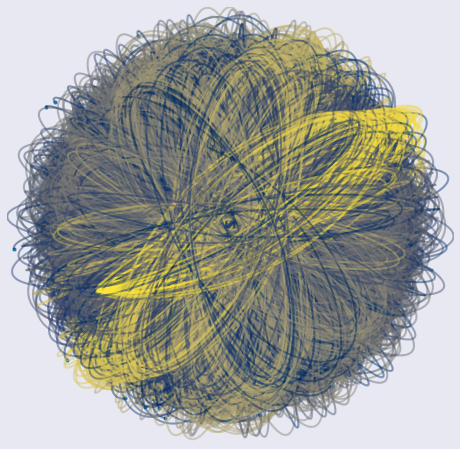

In [339]:
# plot particle trajectories
def make_segments(data, particle_index):
    points = np.array([data[:,particle_index, 0], data[:,particle_index, 1]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

from matplotlib.collections import LineCollection
plt.figure(figsize=(8,8))
line_segments = []
fronts = plt.plot(paths[-1][:,0], paths[-1][:,1], '.', zorder=0)
for i in range(N):
    seg = make_segments(paths, i)
    lc = LineCollection(seg, cmap='cividis', norm=plt.Normalize(0,1), alpha=0.5)
    # Set the values used for colormapping
    lc.set_array(np.linspace(1,0,T))
    lc.set_linewidth(2)
    line = plt.gca().add_collection(lc)
    line_segments.append(seg)
plt.xlim(np.nanmin(paths), np.nanmax(paths))
plt.ylim(np.nanmin(paths), np.nanmax(paths))
plt.xticks([])
plt.yticks([])
plt.savefig('normal.png', dpi=90)
plt.show()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


ValueError: The duration of video __temp__.mp4 (83.3) exceeds the 'maxduration' attribute. You can increase 'maxduration', by passing 'maxduration' parameterto ipython_display function.But note that embedding large videos may take all the memory away !

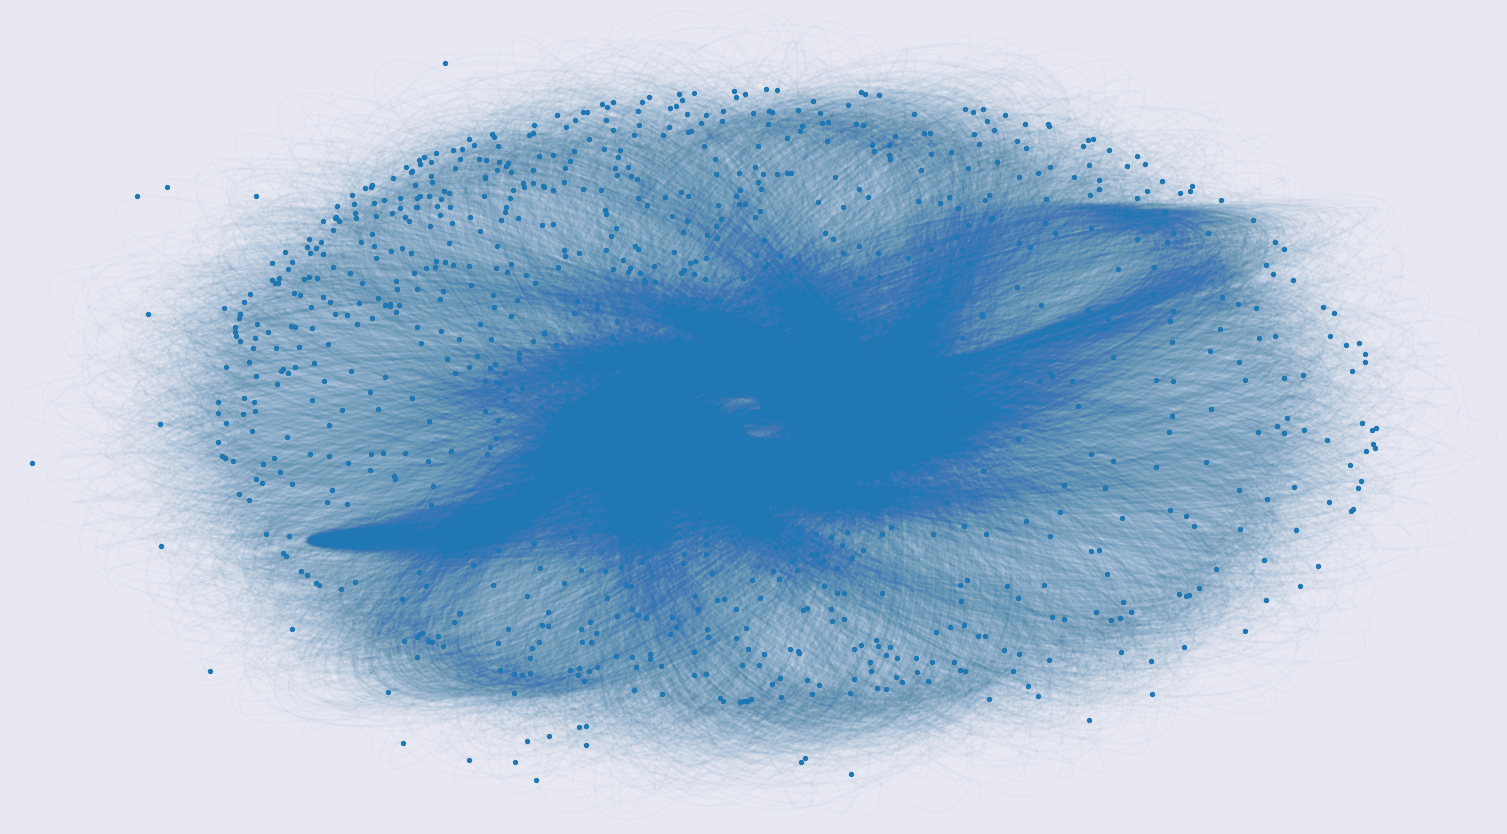

In [340]:
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage


dpi = 96
fig = plt.figure(figsize=(1920 / dpi,1080 / dpi), dpi=dpi)
fps = 30
fronts = plt.gca().plot(paths[-1][:,0], paths[-1][:,1], '.', zorder=0)[0]
plt.xlim(np.nanmin(paths), np.nanmax(paths))
plt.ylim(np.nanmin(paths), np.nanmax(paths))
plt.xticks([])
plt.yticks([])

line_collections = []

def make_frame(t):
    frame = int(fps * t)
    for i in range(N):
        if frame == 0:
            lc = LineCollection(line_segments[i][:frame], cmap='cividis', norm=plt.Normalize(0,1), alpha=0.02)
            line = plt.gca().add_collection(lc)
            line_collections.append(lc)
        lc = line_collections[i]
        # Set the values used for colormapping
        #lc.set_array(np.linspace(1,0,T)[:frame])
        lc.set_segments(line_segments[i][:frame]) 
    j = min(frame, T - 1)
    fronts.set_data(paths[j][:,0], paths[j][:,1])
    return mplfig_to_npimage(fig)

duration = T / fps
animation = VideoClip(make_frame, duration=duration)
animation.ipython_display(fps=fps, loop=True, autoplay=True)

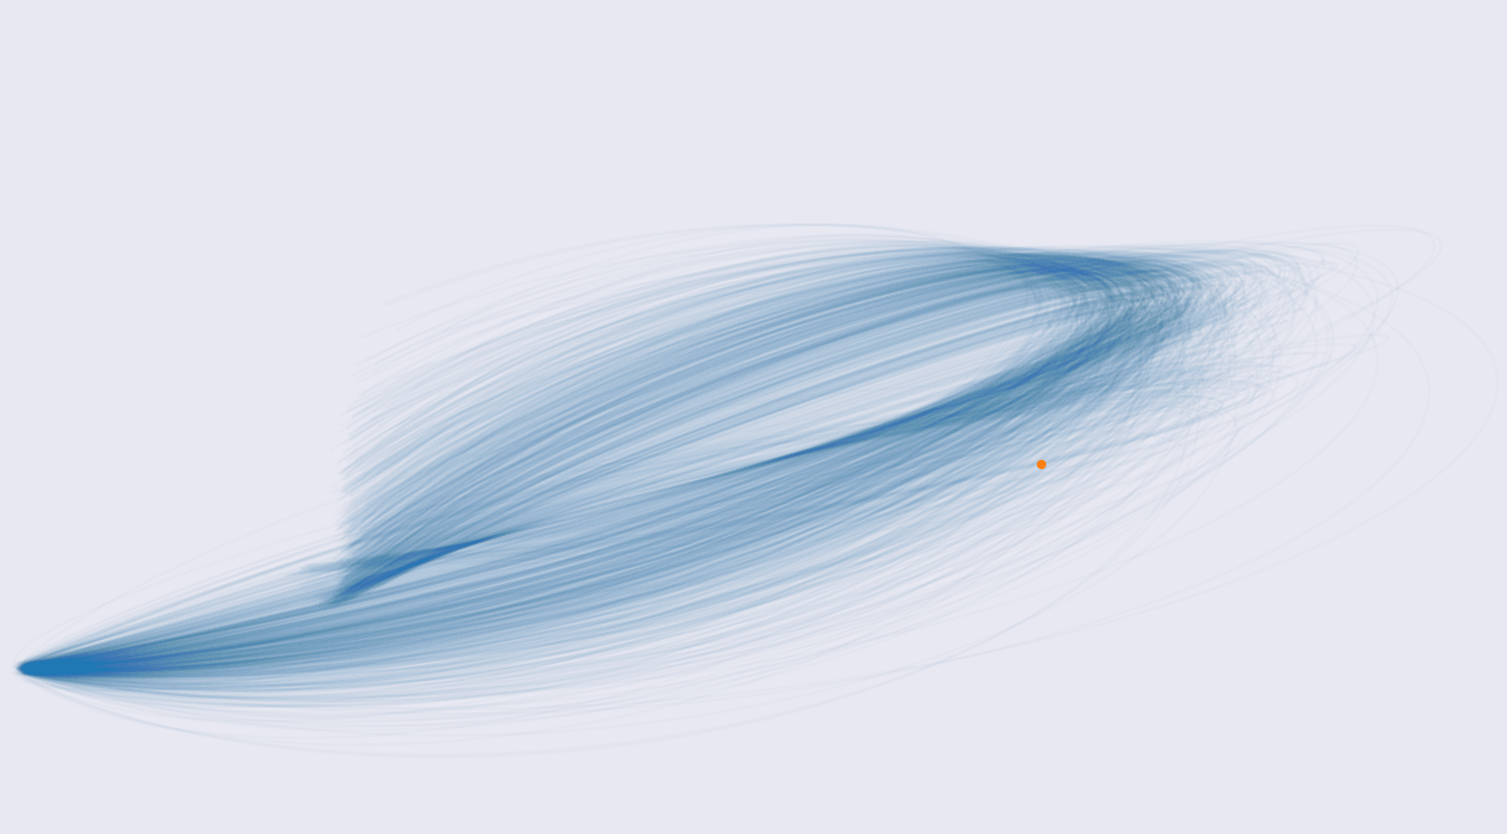

In [327]:
def traj_segments(data):
    points = np.array([data[:, 0], data[:, 1]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

dpi = 96
plt.figure(figsize=(1920 / dpi,1080 / dpi), dpi=dpi)
for i in range(N):
    seg = make_segments(paths, i)
    lc = LineCollection(seg, cmap='cividis', norm=plt.Normalize(0,1), alpha=0.02)
    # Set the values used for colormapping
    #lc.set_array(np.linspace(1,0,T))
    lc.set_linewidth(2)
    line = plt.gca().add_collection(lc)
plt.plot(2.5, 0.5, '-o', color='C1')
mtraj = np.mean(trajs, axis=0)
#plt.plot(mtraj[:,0], mtraj[:,1], color='gray', linewidth=4)
plt.xlim(np.nanmin(paths), np.nanmax(paths))
plt.ylim(np.nanmin(paths), np.nanmax(paths))
plt.xticks([])
plt.yticks([])
plt.savefig('unbiased.png')
plt.show()

In [328]:
# make restraints
import maxent

point = np.array([2.5, 0.5]).reshape(1, 2)
restraints = [maxent.Restraint(lambda p: np.min(np.sum((p - point)**2, axis=1)), 0, maxent.EmptyPrior())]


In [329]:
model = maxent.MaxentModel(restraints)
model.compile(tf.keras.optimizers.Adam(1), 'mean_absolute_error')

In [330]:
trajs =  paths.swapaxes(0,1)

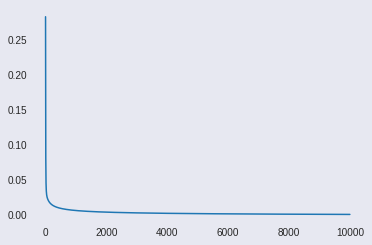

In [331]:
l = model.fit(trajs, batch_size=N, epochs=10000, verbose=0)
plt.plot(l.history['loss'])

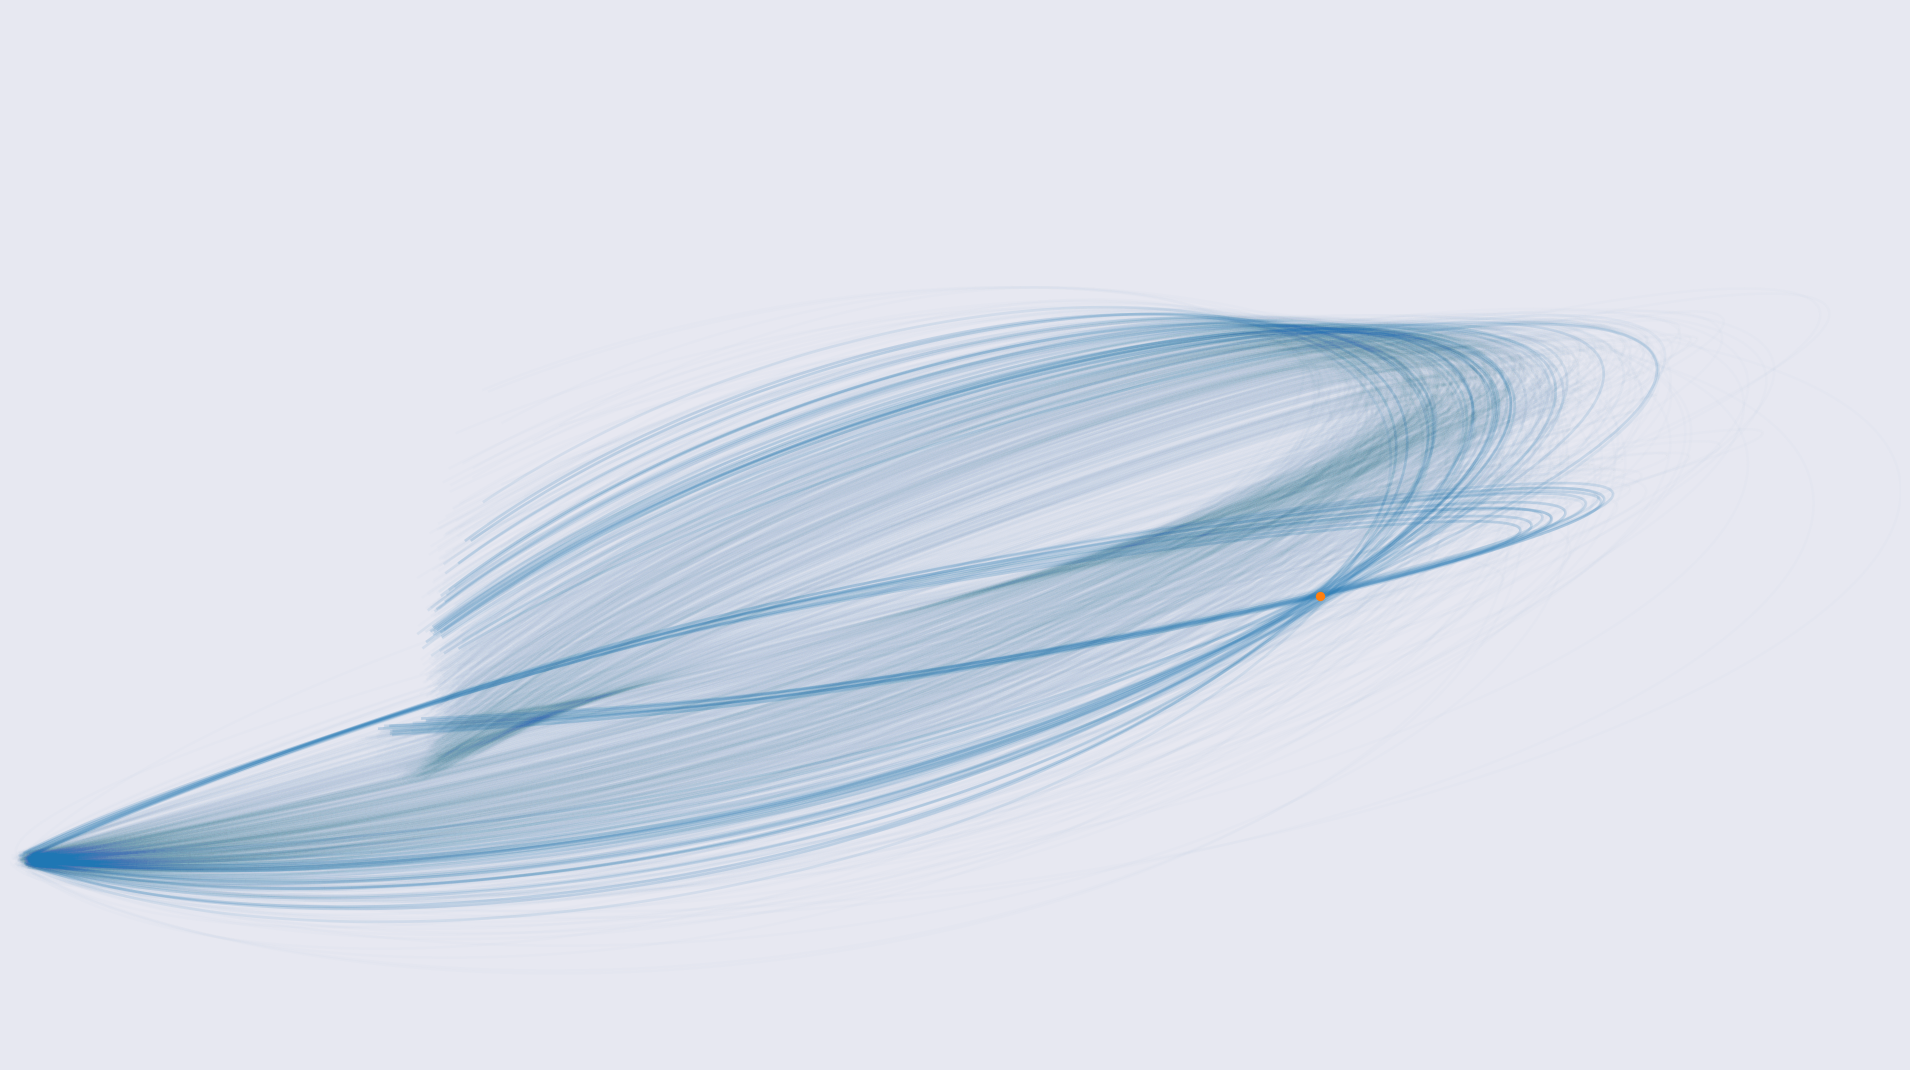

In [332]:
def traj_segments(data):
    points = np.array([data[:, 0], data[:, 1]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

dpi = 96
res = 1080
plt.figure(figsize=(1920 / dpi,1080 / dpi), dpi=dpi)
for i in range(N):
    seg = make_segments(paths, i)
    trans = np.maximum(0.01, 0.2 * model.traj_weights.numpy()[i] / np.max(model.traj_weights))    
    lc = LineCollection(seg, cmap='cividis', norm=plt.Normalize(0,1), alpha=trans)
    # Set the values used for colormapping
    #lc.set_array(np.linspace(1,0,T))
    lc.set_linewidth(2)
    line = plt.gca().add_collection(lc)
wtraj = np.sum(trajs * model.traj_weights[:,np.newaxis, np.newaxis], axis=0)
plt.plot(2.5, 0.5, '-o', color='C1')
#plt.plot(wtraj[:,0], wtraj[:,1], color='C2', linewidth=4)
plt.xlim(np.nanmin(paths), np.nanmax(paths))
plt.ylim(np.nanmin(paths), np.nanmax(paths))
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.savefig('biased.png')
plt.show()

In [286]:
M = 48
all_weights = np.empty((M, N))
yvals = np.linspace(-0.75, 1.5, M)
for i,y in enumerate(yvals):
    point = np.array([2.5, y]).reshape(1, 2)
    restraints = [maxent.Restraint(lambda p: np.min(np.sum((p - point)**2, axis=1)), 0, maxent.EmptyPrior())]
    model = maxent.MaxentModel(restraints)
    model.compile(tf.keras.optimizers.Adam(1), 'mean_absolute_error')
    l = model.fit(trajs, batch_size=N, epochs=2000, verbose=0)
    all_weights[i] = model.traj_weights.numpy()
    print(i, y, l.history['loss'][-1])
    

0 -0.75 0.01599973253905773
1 -0.7021276595744681 0.01813971810042858
2 -0.6542553191489362 0.016954848542809486
3 -0.6063829787234043 0.013830197975039482
4 -0.5585106382978724 0.01041030790656805
5 -0.5106382978723405 0.008286450058221817
6 -0.4627659574468085 0.007100456394255161
7 -0.4148936170212766 0.007097961381077766
8 -0.3670212765957447 0.00826434139162302
9 -0.3191489361702128 0.009741002693772316
10 -0.2712765957446809 0.010090643540024757
11 -0.22340425531914898 0.009903674013912678
12 -0.17553191489361697 0.008805062621831894
13 -0.12765957446808507 0.007504405453801155
14 -0.07978723404255317 0.006903284229338169
15 -0.03191489361702127 0.006521203555166721
16 0.015957446808510634 0.006218902766704559
17 0.06382978723404253 0.006201384123414755
18 0.11170212765957444 0.006407609675079584
19 0.15957446808510634 0.006890334654599428
20 0.20744680851063824 0.007000408601015806
21 0.25531914893617014 0.0064371805638074875
22 0.30319148936170204 0.005771229043602943
23 0.3510

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


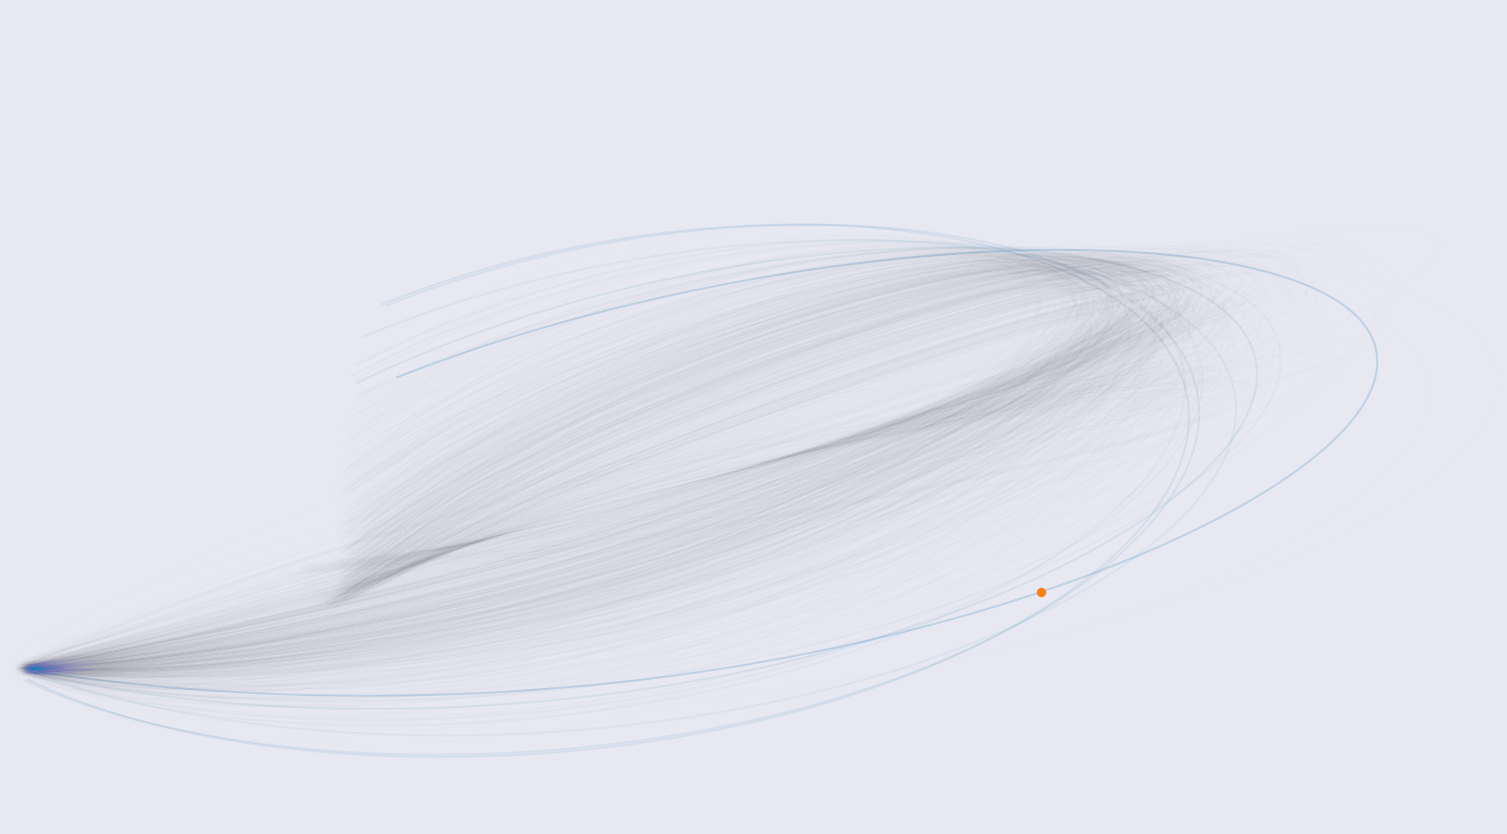

In [311]:
dpi = 96
fig = plt.figure(figsize=(1920 / dpi,1080 / dpi), dpi=dpi)
fps = 30
plt.xlim(np.nanmin(paths), np.nanmax(paths))
plt.ylim(np.nanmin(paths), np.nanmax(paths))
plt.xticks([])
plt.yticks([])

line_collections = []
pplot = plt.gca().plot(2.5, yvals[0], 'o', color='C1')[0]
def make_frame(t):
    frame = int(fps * t)
    # make it rock
    if frame >= M:
        frame = M - (frame % M) - 1    
    frame = max(frame, 0)
    for i in range(N):
        if frame == 0:
            lc = LineCollection(line_segments[i], cmap='cividis', norm=plt.Normalize(0,1), alpha=0.0)
            line = plt.gca().add_collection(lc)
            line_collections.append(lc)            
        trans = np.maximum(0.002, 0.2 * all_weights[frame,i] / np.max(all_weights[frame]))
        lc = line_collections[i]
        lc.set_alpha(trans)
        # Set the values used for colormapping
        #lc.set_array(np.linspace(1,0,T)[:frame])
        pplot.set_data(2.5, yvals[frame])
    return mplfig_to_npimage(fig)

duration = 2 * M / fps
animation = VideoClip(make_frame, duration=duration)
animation.ipython_display(fps=fps, loop=True, autoplay=True)